## Acoustic Signal Processing for Bioacoustics
### 05 - Fundamental frequency tracking using an adaptive notch filter

In this notebook we look at how adaptive notch filters (ANFs) can be used for fundamental frequency tracking. We'll start by looking into the general concept of ANFs and then describe the details of a specific implementation that is based on a Kalman filter.

Written by: Randall Ali (contact r.ali@surrey.ac.uk for questions/errors/suggestions!)

In [40]:
import numpy as np 
import scipy as sp
from scipy import signal
import sounddevice as sd
import soundfile as sf
from matplotlib import pyplot as plt
from  matplotlib import patches
from matplotlib.ticker import FormatStrFormatter
from ipywidgets import * # interactive plots
import IPython
from IPython.display import Audio, Image
%matplotlib ipympl


Data shape:  (78000,)
Recorded Signal:


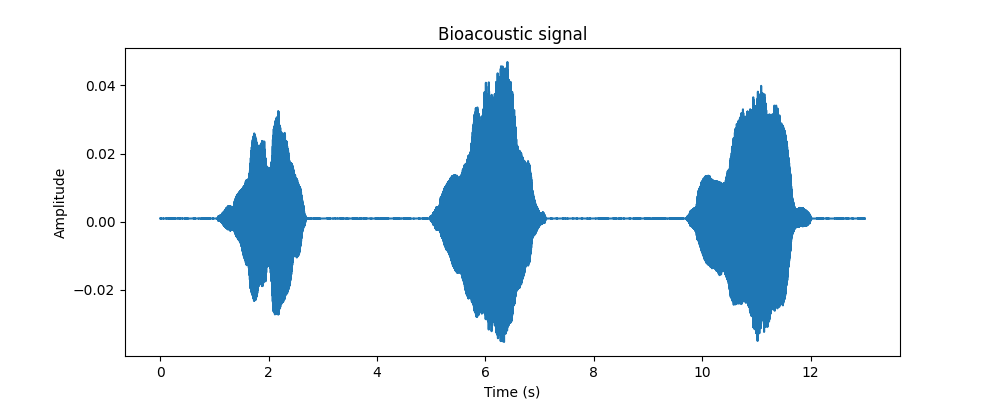

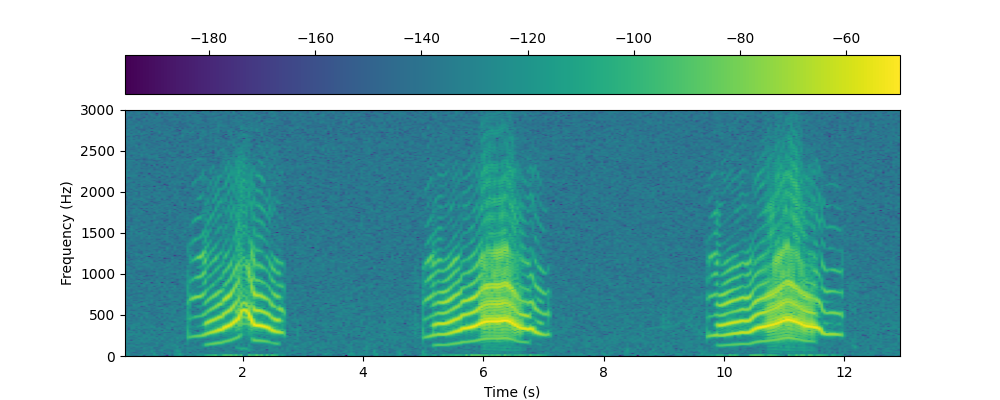

In [41]:
[y_raw,fs] = sf.read('./audio/a1_HT_spotted_hyenas_f0.wav') # Read in your audio file
y = y_raw[2*fs:15*fs]
del y_raw
N = len(y)

t = np.arange(0,N,1)*(1/fs) # time vector


# Plotting
print("Data shape: ", y.shape)
print("Recorded Signal:")
IPython.display.display(Audio(y.T, rate=fs,normalize=True))

# Time domain plot
fig, axes = plt.subplots(figsize=(10, 4)) 
axes.plot(t,y, label = 'Desired')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')
axes.set_title('Bioacoustic signal')

# Computing the spectrogram. We use the package signal which has a spectrogram function
nfft = 512         # number of points for the FFT 
noverlap = nfft/2  # Spectrogram overlap (make it 50 %)

# Compute the spectrogram. We set the mode to obtain the magnitude, 
# i.e absolute magnitude of the short-time Fourier transform (STFT) coefficients.
# Note that we are not concerned with the exact magnitude, i.e. sound pressure level of the signal
f_sg, t_sg, Z_mag = signal.spectrogram(y, fs=fs,nperseg=nfft,window='hann',mode='magnitude',noverlap=noverlap)
Z_dB = 10*np.log10(Z_mag**2) # convert the magnitude to dB


# This is just some extra parameters for the imshow function, which allows you to plot a spectrogram
# The extent parameter is defining the corners of the image
extent = t_sg[0], t_sg[-1], f_sg[0], f_sg[-1]  # this defines the 4 corners of the "image"
fig, axes = plt.subplots(figsize=(10, 4)) 
sp = axes.imshow(Z_dB, origin='lower',aspect='auto',extent=extent)
axes.set_xlabel('Time (s)')
axes.set_ylabel('Frequency (Hz)')
cb = plt.colorbar(sp,ax=[axes],location='top')


### A single parameter adaptive notch filter


#### Signal model
Let us denote our recorded or measured signal in the discrete-time domain, with $n$ being the discrete-time index as $y(n)$ consisting of the sum of two components - (i) a sinusoidal component with time-varying digital angular frequency $\omega_{o}(n) = 2 \pi f_{o}(n)/f_{s}$, where $f_{o}(n)$ is the frequency (Hz), and $f_{s}$ is the sampling frequency (Hz), and (ii) the residual component, $g(n)$. This model is very broad in the sense that $g(n)$ can be representative of a number of signals such as a broadband desired signal, additional harmonics, or simply noise depending on the application. Given our measurement, $y(n)$, our goal is now to track the time-variation of $f_{o}(n)$ using a single parameter adaptive notch filter (ANF).


#### The constrained biquad filter


Let us first recall the biquad filter in the $z$-domain without any constraints:

\begin{equation}
H(z^{-1}) = \frac{b_{o} + b_{1} z^{-1} + b_{2}z^{-2} }{1 + a_{1} z^{-1} + a_{2}z^{-2} }.
\end{equation}  

With $b_{o} = 1$, the biquad can be expressed in polar coordinates (in the complex plane) in terms of a zero radius, $\zeta$, and zero angle $\omega_{z}$, and a pole radius, $\rho$, and pole angle, $\omega_{p}$ as follows
\begin{equation}
H(z^{-1}) = \frac{(1 - \zeta e^{j\omega_{z}}  z^{-1}) (1 - \zeta e^{-j\omega_{z}} z^{-1})  }{(1 - \rho e^{j\omega_{p}} z^{-1}) (1 - \rho e^{-j\omega_{p}} z^{-1})}
\end{equation}  
where $b_{1}  = -(\zeta e^{j\omega_{z}} + \zeta e^{-j\omega_{z}}) = -2 \zeta \cos(\omega_{z})$,  $b_{2} = \zeta^{2}$, $a_{1}  =   -2 \rho \cos(\omega_{p})$,  and $a_{2} = \rho^{2}$. There are 4 parameters here that can be adjusted to configure the biquad in various ways. However, it would be more efficient if we can somehow reduce this to just one parameter, which can be updated by means of some adaptive filter. Hence in order to convert this 4-parameter biquad into a single parameter biquad that acts as a notch filter, two constraints need to be imposed:

1. The poles and zeros need to lie on the same radial line, defined by angle $\omega$ in the complex plane, i.e. $\omega_{z} = \omega_{p} = \omega$. These poles and zeros must also lie completely within the unit circle, where the zeros would be in between the poles and the unit circle in order to define a notch filter. 


2. The zeros all need to lie on the unit circle so that $\zeta = 1$. In this case the frequency component at $\omega$ would be completely attenuated and the pole at the same radial line would once again create a resonance at $\omega$, with the bandwidth of the notch filter becoming narrower as $\rho \rightarrow 1$ .

<!-- \begin{figure}
	\centering
	\includegraphics[width=\linewidth]{figs/bode_plots_biquad_edit}
	\caption{(Left) Pole-zero plot of a constrained biquad IIR filter configured as a notch filter. The poles and zeros lie on the same radial line defined by $\omega = \pi/4$, where the zeros are placed on the unit circle and the poles at a distance $\rho = 0.8$. (Right) The corresponding magnitude and phase response. A notch is clearly visible at $\omega = \pi/4$ with a very narrow bandwidth due to $\rho = 0.8$. }
	\label{fig:bodeplotsbiquadedit}
\end{figure} -->

Imposing these constraints then results in the constrained biquad filter:

\begin{align}
H(z^{-1}) &= \frac{(1 - e^{j\omega}  z^{-1}) (1 -  e^{-j\omega} z^{-1})  }{(1 - \rho e^{j\omega} z^{-1}) (1 - \rho e^{-j\omega} z^{-1})} \nonumber \\
&= \frac{1 - 2 \cos(\omega) z^{-1} + z^{-2} }{1 - 2 \rho \cos(\omega) z^{-1} + \rho^{2} z^{-2}} \nonumber \\
& = \frac{1 - a z^{-1} + z^{-2} }{1 - \rho a z^{-1} + \rho^{2} z^{-2}} 
\end{align}  
where $a \triangleq 2 \cos(\omega) = 2 \cos (2 \pi f/f_{s})$ is the only parameter we need to estimate (since it appears in both the numerator and denominator) and is directly related to the centre frequency, $f$, of the notch filter. Consequently, by adapting the $a$ coefficient, the centre frequency of the notch filter also changes resulting in an ANF. 

Before proceeding to develop an adaptive algorithm to update $a$, let's first quickly have a look at the pole-zero plot of the biquad filter and the subsequent magnitude/phase response. In the following code, we've put together an interactive plot where you can vary $\rho$ and $\omega$ to see the effect on the position of the poles and the corresponding magnitude and phase response.


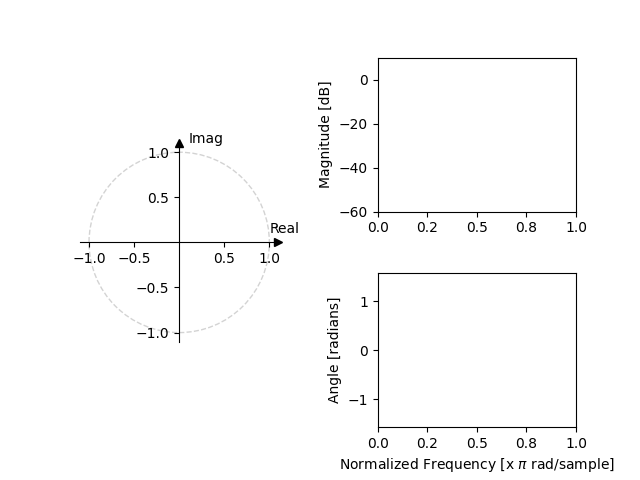

Move the slider to see how the filter changes with the pole radius and centre frequency!
Note that the omega parameter is the true value of omega in radians, but the x-axis of the Magnitude/Phase plots are normalized by $\pi$


interactive(children=(FloatSlider(value=0.8, description='rho', max=0.95, step=0.01), FloatSlider(value=0.7853…

In [31]:
# Setting up the plots
fig, axes = plt.subplot_mosaic([["top left", "top centre"],["top left", "bottom centre"]])
plt.subplots_adjust(wspace=0.5,hspace=0.4)

# Create the unit circle
uc = patches.Circle((0,0), radius=1, fill=False, color='lightgray', ls='dashed')
axes["top left"].add_patch(uc)
 

# Plot the zeros and set marker properties    
t1, = axes["top left"].plot([], [], 'ko', ms=10)
plt.setp( t1, markersize=8.0, markeredgewidth=1.0,
          markeredgecolor='k', markerfacecolor='k')

# Plot the poles and set marker properties
t2, = axes["top left"].plot([], [], 'kx', ms=10)
plt.setp( t2, markersize=8.0, markeredgewidth=3.0,
          markeredgecolor='k', markerfacecolor='r')

axes["top left"].spines['left'].set_position('center')
axes["top left"].spines['bottom'].set_position('center')
axes["top left"].spines['right'].set_visible(False)
axes["top left"].spines['top'].set_visible(False)

axes["top left"].plot(1, 0, ">k", transform=axes["top left"].get_yaxis_transform(), clip_on=False)
axes["top left"].plot(0, 1, "^k", transform=axes["top left"].get_xaxis_transform(), clip_on=False)

# set the ticks
r = 1.1; 
axes["top left"].axis('scaled');
ticks_x = [-1, -0.5, 0.5, 1]; 
ticks_y = [-1, -0.5, 0.5, 1]; 
axes["top left"].set_xticks(ticks_x)
axes["top left"].set_yticks(ticks_y)
axes["top left"].text(1,0.1,'Real');
axes["top left"].text(0.1,1.1,'Imag');



lineMag, = axes["top centre"].plot([], [], 'k')
axes["top centre"].set_ylabel('Magnitude [dB]', color='k')
axes["top centre"].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes["top centre"].set_xlim([0, 1])
axes["top centre"].set_ylim([-60, 10])


# angles = np.unwrap(np.angle(h))
linePh, = axes["bottom centre"].plot([], [], 'k')
axes["bottom centre"].set_ylabel('Angle [radians]', color='k')
axes["bottom centre"].set_xlabel('Normalized Frequency [x $\pi$ rad/sample]')
axes["bottom centre"].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes["bottom centre"].set_ylim([-np.pi/2, np.pi/2])
axes["bottom centre"].set_xlim([0, 1])
# axes["bottom centre"].axis('tight')
plt.show()

# Create the interactive plot
def update(rho = 0.8, omega=np.pi/4):
    
    zeta = 0.9999; # zero radius ~= 1

    bo = 1;
    b1 = -2*np.cos(omega)*zeta;
    b2 = zeta**2;

    a1 = -2*np.cos(omega)*rho;
    a2 = rho**2;

    b = [bo,b1,b2];
    a = [1,a1,a2];

    # FREQZ to get magnitude and phase
    w, h = signal.freqz(b,a)
    Mag = 20 * np.log10(abs(h))
    freq_axis = w/np.pi
    angles = np.unwrap(np.angle(h))
    
    # Get the poles and zeros
    p = np.roots(a)
    z = np.roots(b)


    lineMag.set_data(freq_axis, Mag)
    linePh.set_data(freq_axis, angles)
    t1.set_data(z.real, z.imag)
    t2.set_data(p.real, p.imag)

print('Move the slider to see how the filter changes with the pole radius and centre frequency!')
print('Note that the omega parameter is the true value of omega in radians, but the x-axis of the Magnitude/Phase plots are normalized by $\pi$')
interact(update, rho = (0,0.95,0.01), omega=(0,np.pi,np.pi/16)); 

### Least Mean Square Adaptive Notch Filter (LMS-ANF)
$\newcommand{\ahat}{\hat{{a}}}$
Let's recall the constrained biquad filter expression:

\begin{align}
H(z^{-1}) & = \frac{1 - a z^{-1} + z^{-2} }{1 - \rho a z^{-1} + \rho^{2} z^{-2}} 
\end{align} 

The strategy here is that we can choose $\rho$, which effectively controls the filter bandwidth, and then we need to find an update equation for $a$, which will consequently update the frequency to be notched, $\omega$, since $a \triangleq 2 \cos(\omega) = 2 \cos (2 \pi f/f_{s})$.

An efficient method to estimate $a$ can be derived by considering the direct form II of the constrained biquad filter as illustrated in Fig. 1. The implementation equations are given as  
\begin{align}
s(n) &=  y(n) + \rho a(n-1) s(n-1) - \rho^{2} s(n-2)  \hspace{2cm}  (1) \\
e(n) &= s(n) - a(n-1)s(n-1) + s(n-2) \hspace{2.6cm}  (2)
\end{align}

where $y(n)$ is the input to the constrained biquad filter (our measured signal), $e(n)$ is the output, and $s(n)$ is introduced as an auxiliary variable. In this form, the biquad filter is explicitly split into two sections. The first is a two-pole resonance IIR filter illustrated on the left side of Fig. 1, corresponding to the denominator of $H(z^{-1})$ and whose difference equation is given by equation (1). The second section is a finite impulse response (FIR) two-zero notch filter illustrated on the right side of Fig.1, corresponding to the numerator of $H(z^{-1})$ and whose difference equation is given by equation (2).

<br>
<br>

<div>
<center> <img src="img/biquad_block.png" width="650"/> <center/>
    <p style="text-align:center">Fig. 1 - Direct Form II of the constrained biquad filter</p>
</div>

<br>
<br>


We can now proceed to estimate $a$ by minimising the mean-squared output signal power of the filter, i.e. minimizing the mean-square of $e(n)$. In [Travassos-Romano1988](https://ieeexplore.ieee.org/document/196857), it was proposed to only update the FIR section of the biquad filter, i.e. estimate the coefficient $a$ in the FIR section, and since this $a$ occurs in both the numerator and denominator in  $H(z^{-1})$, this estimate can be simply copied to the IIR section of the biquad filter. An LMS algorithm can then be used to estimate $a$ by making use of equation (2) as follows  

\begin{align}
\hat{a}(n) &=  \hat{a}(n-1) + \mu \left( - \frac{\partial e^{2}(n)}{\partial a(n-1)}\right) \nonumber \\
&= \hat{a}(n-1) +  2 \hspace{0.01cm} \mu \hspace{0.05cm} s(n-1)   e(n) 
\end{align}

where $\mu$ is the step size parameter. 



<!-- The algorithm for computing frequency estimates using such an LMS update is given in Algorithm 1 and we subsequently refer to the resulting frequency tracker as LMS-ANF. In Algorithm 1, $N$ is the length of the signal, $y(n)$, and due to the $s(n-2)$ term, we simply start the for loop from $n=2$ and initialize $s(0)$ and $\ahat(1),s(1)$. Since $\arccos(\ahat(n)/2)$ does not exist for $|\ahat(n)| > 2$, we have additionally imposed a constraint on the values of $\ahat(n)$ such that $\ahat(n)$ is re-initialized to zero when $|\ahat(n)| > 2$, {i.e. we restart the algorithm\footnote{{This is certainly not the only strategy to deal with out of range values for $\ahat(n)$, but an investigation into this aspect of the ANF is out of the scope of this work.}} with an initial frequency estimate at half of the Nyquist frequency.} {By defining the computational complexity as the number of multiplications per recursion, from Algorithm 1, we can deduce that the LMS-ANF has a computational complexity of 11 multiplications per recursion.} It should also be noted that in addition to obtaining a sample-by-sample update of the estimated frequency, we also obtain a sample-by-sample update of the output (i.e. adaptive notch-filtered input signal), $e(n)$, however we are only concerned with the former as it pertains to the frequency tracker. 

<br>
<br>

<div>
<img src="img/LMS_algo.png" width="500"/>
</div>

<br>

So now let's code this algorithm! -->

### Kalman-Based Adaptive Notch Filter (KalmANF)
$\newcommand{\xhat}{\hat{\mathbf{x}}}$


An alternative way we can represent this type of ANF based on a constrained biquad is by a [state-space representation](https://en.wikipedia.org/wiki/State-space_representation), which is a common framework for dynamic linear systems, from which one can apply a Kalman filter to estimate the so-called state. For the ANF, the state should contain the parameter $\ahat$ as this is the time-parameter we would like to estimate. But firstly, let's briefly re-call the state-space representation and the corresponding Kalman filter to estimate the state. 


\begin{align}
\mathbf{x}(n) &= \mathbf{C} \mathbf{x}(n-1) + \mathbf{w}(n)  &  (K.1)\\
\mathbf{z}(n) &= \mathbf{H} \mathbf{x}(n) + \mathbf{v}(n) &  (K.2)
\end{align}

where $\mathbf{x}(n) \in \mathbb{R}^{L}$ is the state vector at time $n$, $\mathbf{C} \in \mathbb{R}^{L \times L}$ is the state-transition matrix, $\mathbf{w}(n) \in \mathbb{R}^{L}$ is the process noise vector, which is modelled as a zero-mean, Gaussian process with covariance matrix $\mathbf{Q} \in \mathbb{R}^{L \times L}$,   $\mathbf{z}(n) \in \mathbb{R}^{M}$ is the measurement vector, $\mathbf{H} \in \mathbb{R}^{M \times L}$ is the measurement matrix, and $\mathbf{v}(n) \in \mathbb{R}^{M}$ is the measurement noise vector, also modelled as a zero-mean, Gaussian process but with covariance matrix $\mathbf{R} \in \mathbb{R}^{M \times M}$.


For dynamical systems which can be described in the state-space form of equations (K.1) and (K.2), the state-vector at time $n$ can be estimated using a Kalman filter. The Kalman filter consists of two steps: (i) a prediction (or update) stage and, (ii) an estimation (or measurement) stage, which are performed in a recursive manner, and are given by the following equations

\begin{align}
\xhat(n | n-1) &= \mathbf{C}\xhat( n-1) &  (K.3) \\
\hat{\mathbf{P}}(n | n-1) &= \mathbf{C}\hat{\mathbf{P}}(n-1)\mathbf{C}^{T} + \mathbf{Q} &  (K.4)\\
\mathbf{K}(n) &= \hat{\mathbf{P}}(n | n-1) \mathbf{H}^{T} \left(\mathbf{H}  \hat{\mathbf{P}}(n | n-1) \mathbf{H}^{T}  + \mathbf{R}   \right)^{-1} &  (K.5) \\
\mathbf{v}(n) &= \mathbf{z}(n) - \mathbf{H}\xhat(n | n-1) &  (K.6)\\
\xhat(n) &= \xhat(n | n-1) + \mathbf{K}(n)\mathbf{v}(n) &  (K.7)\\
\hat{\mathbf{P}}(n)&= \left[ \mathbf{I} -  \mathbf{K}(n)\mathbf{H} \right] \hat{\mathbf{P}}(n | n-1) &  (K.8)
\end{align}

where $\mathbf{K}(n)$ is the Kalman gain, the notation $\xhat(n|n-1)$ denotes a prediction of $\mathbf{x}(n)$ based on measurement samples up to time $n-1$, and the prediction error is defined as $\mathbf{x}(n) - \xhat(n|n-1)$ with a covariance matrix, $\mathbf{P}(n)$, whose estimate is denoted as $\hat{\mathbf{P}}(n)$. The first two equations, (K.3) and (K.4), are the prediction equations, which update the state and the covariance matrix of the prediction error from measurement samples up to time $n-1$. The subsequent equations are the estimation equations. $\mathbf{v}(n)$ in (K.5) is also referred to as the innovation signal, which is the error between the new measurement at time $n$ and the prediction based on measurement samples up to time $n-1$, and is used to update the state-vector estimate at time $n$ in (K.6) along with the Kalman gain, $\mathbf{K}(n)$, computed in (K.7). The prediction error covariance matrix at time $n$ is finally updated in (K.8), and the entire sequence of equations is repeated for the next time index. 


By following the strategy of estimating $a$ in the FIR section of the constrained biquad filter from Fig. 1 and copying the estimate to the IIR section, we can use (1) and (2) (see previous cell) to define a state-space model corresponding to the form of (K.1) and (K.2) as follows:

\begin{align}
\underbrace{\begin{bmatrix} a(n)  \\ 
	1 \end{bmatrix}}_{\mathbf{x}(n)} &= \underbrace{\begin{bmatrix} 1 & 0  \\ 
	0 & 1 \end{bmatrix}}_{\mathbf{C}}  \underbrace{\begin{bmatrix} a(n-1)  \\ 
	1 \end{bmatrix}}_{\mathbf{x}(n-1)}  + \underbrace{\begin{bmatrix} w(n)  \\ 
	0 \end{bmatrix}}_{\mathbf{w}(n)} & (K.9) \\
\underbrace{s(n)}_{\mathbf{z}(n)}  &= \underbrace{\begin{bmatrix} s(n-1)  & -s(n-2) \end{bmatrix}}_{\mathbf{H}(n)} \underbrace{\begin{bmatrix} a(n)   \\ 
	1 \end{bmatrix}}_{\mathbf{x}(n)} + \underbrace{e(n)}_{\mathbf{v}(n)} & (K.10)
\end{align}


Focusing firstly on (K.10) and comparing with (K.2), it is evident that we have defined $s(n)$ as our measurement, which is a scalar. Although we do not explicitly measure $s(n)$, it is a function of the input signal, $y(n)$, and therefore we can use (2) with $a(n-1) = \ahat(n-1)$ to obtain a value for $s(n)$. We can also observe that the measurement matrix, $\mathbf{H}(n)$, is now time-varying and depends on two previous measurement samples. The measurement noise vector is also simply a scalar and is the error, $e(n)$, we want to minimize in the ANF context. 

Finally we  can observe that the state vector, $\mathbf{x}(n)$ is a function of $a(n)$, which is the parameter that we want to estimate. With the measurement equation defined, the state equation of (K.2) follows directly from \eqref{eq:state_space_model_stateeqn}, where $\mathbf{C}$ is simply an identity matrix and $\mathbf{w}(n)$ has one non-zero value, $w(n)$, since it is only $a(n)$ that needs to be updated.

We can simply proceed to use the equations (K.3)-(K.8) to obtain an estimate for $a(n)$. However, because of the low dimensionality of the state-space equations defined in (K.9) and (K.10), we can also substitute them into  (K.3)-(K.8) to obtain simpler and more intuitive expressions to understand how $a(n)$ is being estimated. 


Since $\mathbf{C}$ is an identity matrix, (K.3) is simply
\begin{align}
%\xhat(n | n-1) &= \xhat( n-1) \nonumber \\
\xhat(n | n-1) = \begin{bmatrix} \ahat(n|n-1)  \\ 
1 \end{bmatrix}					& = \begin{bmatrix} \ahat(n-1)  \\ 
					1 \end{bmatrix} & (K.11)
\end{align}


We initialize the estimate of the covariance matrix of the prediction error, $\hat{\mathbf{P}}(n)$, and the covariance matrix of the process noise, $\mathbf{Q}$ with only one non-zero entry so that (K.4) reduces to


\begin{align}
\hat{\mathbf{P}}(n | n-1)  = \begin{bmatrix}
\hat{p}(n | n-1) & 0 \\
0 & 0
\end{bmatrix} & =  \begin{bmatrix}
							\hat{p}(n-1) + q & 0 \\
							0 & 0
							\end{bmatrix}  & (K.12)
\end{align}

where $q$ is the variance of $w(n)$, which is a hyperparameter of the proposed algorithm.

Since the measurement equation of (K.10) is scalar, the covariance of the measurement noise boils down to the variance of $e(n)$, which we denote as $r$, another hyperparameter. Using the time-varying measurement matrix, $\mathbf{H}(n)$ from (K.10) and $\hat{\mathbf{P}}(n | n-1) $ from (K.12), the Kalman gain follows from (K.5) as

\begin{align}
\mathbf{K}(n) &=  \frac{s(n-1)} {s^{2}(n-1) + \frac{r}{\hat{p}(n | n-1) }   } \begin{bmatrix}
1 \\
0 
\end{bmatrix} & (K.13)
%
\end{align} 



From (K.7) we then obtain the update equation for the state vector. Since the second element in the state vector is always 1 and the Kalman gain is zero for this entry, we will in fact just have a scalar update equation as follows:

\begin{align}
\ahat(n) &= \ahat(n-1) + \frac{s(n-1)} {s^{2}(n-1) + \frac{r}{\hat{p}(n | n-1) }   }   e(n) & (K.14)
\end{align}

where using (K.6), $e(n)$ is given by

\begin{align}
e(n) &= s(n) -  s(n-1) \ahat(n-1)   + s(n-2) & (K.15)
\end{align}

which is identical to (2) but with $a(n-1) = \hat{a}(n-1)$.

Finally from (K.8), the update of the first and only non-zero element of the covariance matrix of the prediction error is


\begin{align}
\hat{p}(n) &= \left(1 - \frac{s^{2}(n-1)} {s^{2}(n-1) + \frac{r}{\hat{p}(n | n-1) }} \right) \hat{p}(n | n-1) & (K.16)
\end{align}


It can now be seen that (K.14) is indeed in the form of a normalized LMS (NLMS) filter update, {with a time-varying step size of  $1/ \left[s^{2}(n-1) + r/\hat{p}(n | n-1) \right]$}, where the term $s^{2}(n-1)$ provides the normalization and  $r/\hat{p}(n | n-1) $ acts as a time-varying regularization parameter. As opposed to having to choose this regularization parameter in a heuristic manner, an optimal value is now defined in the Kalman filter context as the ratio of the variance of the measurement noise to the variance of the prediction error obtained from measurements samples up to time $n-1$. We also note that a similar, yet time-invariant expression for the NLMS parameter was obtained in a Bayseian framework.


A summary of the KalmANF frequency tracker is given in Algorithm 2. Due to the $s(n-2)$ term, we simply start the for loop from $n=2$ and initialize $s(0)$, $\ahat(1),s(1)$, and $\hat{p}(1)$. The constraints are also imposed on $\ahat(n)$ to ensure $ \arccos(\ahat(n)/2)$ exists. {We can also deduce that the KalmANF has a computational complexity of 14 multiplications per recursion (in line 7, only two multiplications are counted since $k(n)$ would have been computed in line 4).}

<br>
<br>

<div>
<img src="img/KalMANF_algo.png" width="500"/>
</div>

Let's code this up and see how it performs.

In [36]:
# KalmANF function

def kalmanf (y, fs, rho, q, r):
    
    '''
    Kalman-Based Adaptive Notch Filter (KalmANF)
    

    Input arguments:
        y       - input data vector (Lx1)
        fs      - sampling frequency (Hz)
        rho     - pole raduis (value between 0 and 1, with values closer to 1 creating a narrower notch)
        q       - Covariance of process noise
        r       - Covariance of measurement noise
        
    Returns:
        f_kal   - Estimated frequency over time (Lx1)
        a_kal   - Estimated filter coefficient over time (Lx1)
        e_kal   - Output from notch filter (Lx1)
        
    '''  


    s_kal = np.zeros(len(y)) # intermediate variable of ANF
    e_kal = np.zeros(len(y)) # output of ANF
    a_kal = 2*np.ones(len(y)) # coefficient to be updated - note that I made the initial value 2, so that the starting freq. estimate = 0 Hz.
    f_kal = np.zeros(len(y)) # frequency to be tracked
    
    p_cov = 0 # initialise covariance of the error
    K = np.zeros(len(y)) # Kalman gain
        
    for n in np.arange(2,len(y),1): # start loop from two samples ahead because we need samples at m-1 and m-2 
        
        # Prediction
        # a(n|n-1) is simply a(n-1) since the state transition matrix is an identiy
        p_cov = p_cov + q; # update covariance of prediction error
        
        
        # Estimation
        s_kal[n] = y[n] + rho*s_kal[n-1]*a_kal[n-1] - (rho**2)*s_kal[n-2] # Define s_kal from data
        K[n] = (s_kal[n-1])/( (s_kal[n-1]**2) + r/p_cov )
        e_kal[n] = s_kal[n] - s_kal[n-1]*a_kal[n-1] + s_kal[n-2] 
        a_kal[n] = a_kal[n-1] + K[n]*e_kal[n]
    
        # Update covariance of error
        p_cov = (1 - K[n]*s_kal[n-1])*p_cov
        
        # Compute frequency
        if (a_kal[n] > 2) or (a_kal[n] < -2):
#             print('a = '+str(a_kal[n])+ ' is out of range, resetting to 0')
            a_kal[n] = 2 # reset coefficient if a is out of range to compute acos
        
        omega_hat_kal = np.arccos(a_kal[n]/2)
        f_kal[n] = (omega_hat_kal*fs)/(2*np.pi) # estimated frequency
    
    return f_kal, a_kal, e_kal


Move the slider to see how the hyperparameters affect performance 


interactive(children=(FloatSlider(value=0.9, continuous_update=False, description='rho', max=0.99, min=0.2, st…

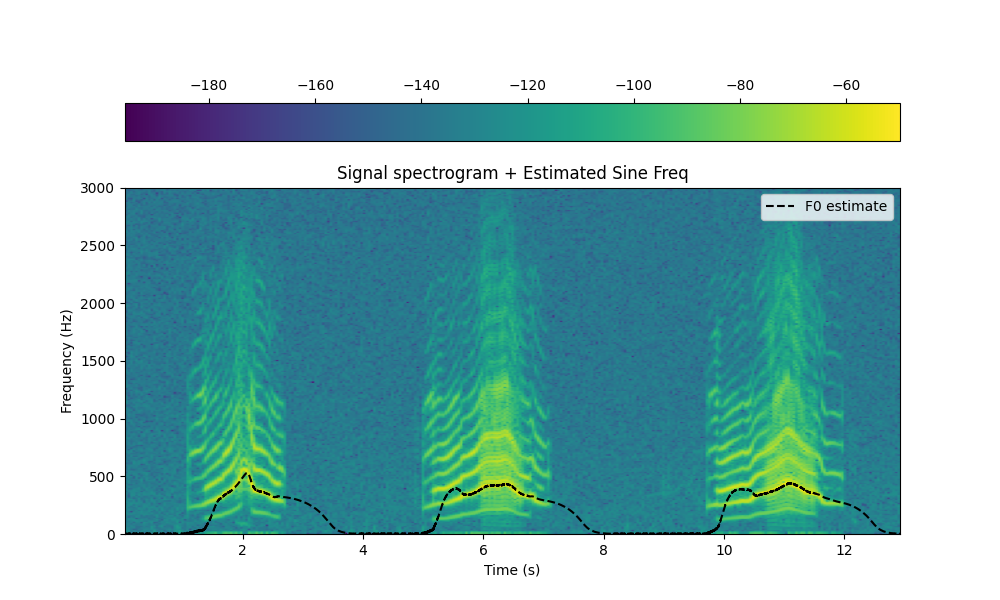

In [37]:
# Let's apply the frequency tracker and observe the effect of the parameters.


####### Computing spectrograms ######

# Spectrogram parameters
nfft = 512         # number of points for the FFT 
noverlap = nfft//2  # Spectrogram overlap (make it 50 %)

# Spectrogram of the input signal
f_sg, t_sg, Z_mag = signal.spectrogram(y, fs=fs,nperseg=nfft,window='hann',mode='magnitude',noverlap=noverlap)
Z_dB = 10*np.log10(Z_mag**2) # convert the magnitude to dB
extent = t_sg[0], t_sg[-1], f_sg[0], f_sg[-1]  # this defines the 4 corners of the "image" for the imshow function to plot spectrogram

min_dB = -140
max_dB = -40


fig, axes = plt.subplots(figsize=(10, 6)) 
sp = axes.imshow(Z_dB, origin='lower',aspect='auto',extent=extent, vmin=np.min(Z_dB),vmax=np.max(Z_dB))
kalfreq_plt, = axes.plot([], [], 'k--',label='F0 estimate')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Frequency (Hz)')
axes.set_xlim(t_sg[0], t_sg[-1])
axes.set_title('Signal spectrogram + Estimated Sine Freq')
cb = plt.colorbar(sp,ax=[axes],location='top', pad=0.1)
axes.legend()
    
def update(rho = 0.9, q =0.001):

    # Apply the KalmANF algorithm
    f_kal, a_kal, e_kal = kalmanf (y, fs, rho=rho, q=q, r=1) 
    kalfreq_plt.set_data(t,f_kal)

    
print('Move the slider to see how the hyperparameters affect performance ')
out = interact(update, rho=FloatSlider(value = 0.9, min=0.2, max=0.99, step = 0.01, continuous_update=False), 
                 q=FloatSlider(value = 0.001, min=0.000001, max=0.01, step = 0.000001, readout_format='.5f', continuous_update=False)); 




### References

This notebook is largely based on the following paper:

1. R. Ali, T. van Waterschoot, "[A frequency tracker based on a Kalman filter update of a single parameter adaptive notch filter](https://ftp.esat.kuleuven.be/pub/SISTA/rali/Reports/23-57.pdf)", Proceedings of the 26th International Conference on Digital Audio Effects (DAFx23), Copenhagen, Denmark, September 2023.

Here are a few references for the classical ANF that uses an LMS filter:

2. A. Nehorai, “[A minimal parameter adaptive notch filter with constrained poles and zeros](https://ieeexplore.ieee.org/document/1164643),” IEEE Trans. Acoust., Speech, Signal Process., vol. 33, no. 4, pp. 983–996, 1985.


3. J. M. Travassos-Romano and M. Bellanger, “[Fast Least Squares Adaptive Notch Filtering](https://ieeexplore.ieee.org/document/196857),” IEEE Trans. Acoust., Speech, Signal Process., vol. 36, no. 9, pp. 158–161, 1988.


4. J. M. Kates, “[Feedback Cancellation in Hearing Aids: Results from a Computer Simulation](https://ieeexplore.ieee.org/document/80875),” IEEE Trans. Signal Process., vol. 39, no. 3, pp. 553–562, 1991.

For more on adaptive filters in general, the classic text is recommended:

5. Haykin, Simon. Adaptive filter theory. 4th Upper Saddle River, NJ: Prentice Hall, 2002.

And finally for more on other types of frequency tracking methods, including multi-pitch estimation:

6. Christensen, M.G., Jakobsson, A. (2009). Fundamentals. In: Multi-Pitch Estimation. Synthesis Lectures on Speech and Audio Processing. Springer, Cham. https://doi.org/10.1007/978-3-031-02558-7_1